In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import networkx as nx
import community.community_louvain as community
from scipy.stats import linregress
!pip install yahoo_fin
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import itertools
from yahoo_fin import stock_info as s
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Get Data**

In [4]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
companies=[]
for i in range(len(df['Symbol'])):
  companies.append(df['Symbol'][i])

In [5]:
data = {}

for ticker in companies:
    # Create a Ticker object for the current ticker
    ticker_obj = yf.Ticker(ticker)

    # Get the industry sector of the current ticker
    if 'sector' in ticker_obj.info:
        sector = ticker_obj.info['sector']
    else:
        sector = 'N/A'

    # Get historical data for the current ticker
    ticker_data = ticker_obj.history(start="2018-01-01", end="2022-12-31")

    # Add a 'Symbol' column with the current ticker symbol
    ticker_data['Symbol'] = ticker

    # Add a 'Sector' column with the industry sector of the current ticker
    ticker_data['Sector'] = sector

    # Store the historical data for the current ticker in the dictionary
    data[ticker] = ticker_data

# Concatenate the historical data for all tickers into a single DataFrame
df = pd.concat(data.values(), keys=data.keys())


Got error from yahoo api for ticker BRK.B, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BRK.B: No timezone found, symbol may be delisted
BF.B: No data found for this date range, symbol may be delisted


In [6]:
col_p = 'close'

concatenated_df = pd.concat(data.values(), keys=data.keys())
concatenated_df.reset_index(inplace=True)
concatenated_df.rename(columns={'level_0': 'ticker', 'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'vol'}, inplace=True)

# Create the df_price DataFrame
df_price = concatenated_df[['ticker', 'date', col_p]]
df_price = df_price.drop_duplicates(subset=['date', 'ticker'], keep='last')
df_price['date'] = pd.to_datetime(df_price['date'], format='%Y-%m-%d')
df_price.set_index(['date', 'ticker'], inplace=True)
df_price = df_price.unstack()[col_p]
df_price.reset_index(inplace=True)
df_price.fillna(method='bfill', inplace=True)
df_price.fillna(method='ffill', inplace=True)

**Compute log returns**

In [7]:
import scipy.signal
t = 1
for key in df_price.columns:
    if key not in companies:
        continue
    try:
        df_price[key] = np.log(df_price[key]) - np.log(df_price[key].shift(t))
    except:
        print (key)
df_price.set_index('date',inplace=True)

d

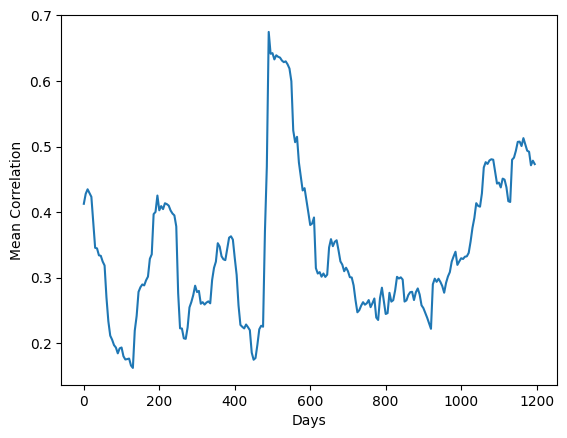

In [25]:
# Implement the sliding window approach
window_size = 63
step_size = 5
corr_dict = {}

for i in range(0, len(df_price) - window_size + 1, step_size):
    dkey = i
    corr_matrix = df_price.iloc[i:(i + window_size)].corr(method='pearson')
    corr_matrix.fillna(0, inplace=True)
    corr_dict[dkey] = corr_matrix

# Plot the average correlation over time
x = list(corr_dict.keys())
y = [np.mean(np.abs(corr_matrix.values)) for corr_matrix in corr_dict.values()]

plt.plot(x, y)
plt.xlabel('Days')
plt.ylabel('Mean Correlation')
plt.show()

In [9]:
def build_network(corr_matrix, threshold):
    G = nx.Graph()
    G.add_nodes_from(corr_matrix.index)

    # Add edges based on the correlation threshold
    edges = [(i, j, {'weight': abs(corr_matrix.loc[i, j])}) for i, j in itertools.combinations(corr_matrix.index, 2) if abs(corr_matrix.loc[i, j]) >= threshold]
    G.add_edges_from(edges)

    return G



In [10]:
num_keys = len(corr_dict.keys())
print(f"The corr_dict dictionary has {num_keys} keys.")

The corr_dict dictionary has 240 keys.


In [ ]:
dynamic_networks = {}
threshold = 0.5 

for dkey, corr_matrix in corr_dict.items():
    dynamic_networks[dkey] = build_network(corr_matrix, threshold)
    print(f"{dkey} network built with {len(dynamic_networks[dkey])} nodes.")


In [12]:
degree_centrality = {dkey: nx.degree_centrality(network) for dkey, network in dynamic_networks.items()}

In [ ]:
betweenness_centrality = {}
for dkey, network in dynamic_networks.items():
    print(f"Calculating betweenness centrality for dynamic network {dkey}...")
    betweenness_centrality[dkey] = nx.betweenness_centrality(network)


In [ ]:
closeness_centrality = {}
for dkey, network in dynamic_networks.items():
    print(f"Calculating closeness centrality for dynamic network {dkey}...")
    closeness_centrality[dkey] = nx.closeness_centrality(network)


In [ ]:
communities = {}
for dkey, network in dynamic_networks.items():
    print(f"Finding communities for dynamic network {dkey}...")
    communities[dkey] = community.best_partition(network)

In [16]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**draw with no sector colors**

In [19]:
import imageio
from IPython.display import Image

In [26]:
def draw_network(G, pos=None, title=None, filename=None):
    plt.figure(figsize=(10, 10))
    if not pos:
        pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=30, edge_color='grey', with_labels=False)
    if title:
        plt.title(title)
    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

In [27]:
pos = None  # Initialize position to None to use the spring layout in the first network
filenames = []

for dkey, network in dynamic_networks.items():
    print(dkey)
    title = f'Day {dkey}'
    filename = f'network_{dkey}.png'
    draw_network(network, pos, title, filename)
    filenames.append(filename)
    pos = nx.spring_layout(network)  # Update position based on the current network

0
5


KeyboardInterrupt: ignored

In [18]:
with imageio.get_writer('network_animation.gif', mode='I', duration=0.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove the individual image files
for filename in filenames:
    os.remove(filename)

NameError: ignored

**draw with network colors**

In [1]:
def draw_network(G, pos=None, title=None, filename=None):
    plt.figure(figsize=(10, 10))
    if not pos:
        pos = nx.spring_layout(G, seed=42)
    
    nx.draw(G, pos, node_size=30, edge_color='grey', with_labels=False)
    nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8, font_color='black')
    
    if title:
        plt.title(title)
    if filename:
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

In [37]:
sector_dict = {}

for ticker, ticker_data in data.items():
    if not ticker_data.empty:
        sector_dict[ticker] = ticker_data['Sector'][0]
    else:
        sector_dict[ticker] = 'N/A'

In [42]:
# Modify sector names to be consistent with sector_colors
for ticker, sector in sector_dict.items():
    if sector == 'Healthcare':
        sector_dict[ticker] = 'Health Care'
    elif sector == 'Consumer Cyclical':
        sector_dict[ticker] = 'Consumer Discretionary'

In [45]:
import matplotlib.colors as mcolors

def draw_network(G, pos=None, sector_dict=None, title=None, filename=None):
    # Define colors for each sector
    sector_colors = {
    'Health Care': 'tab:red',
    'Consumer Discretionary': 'tab:blue',
    'Information Technology': 'tab:green',
    'Communication Services': 'tab:orange',
    'Financials': 'tab:purple',
    'Materials': 'tab:brown',
    'Real Estate': 'tab:pink',
    'Industrials': 'tab:gray',
    'Energy': 'tab:olive',
    'Utilities': 'tab:cyan',
    'Consumer Staples': 'tab:red',  # Use the same color as 'Consumer Defensive'
    'Consumer Defensive': 'tab:red',
    'Basic Materials': 'tab:brown',  # Use the same color as 'Materials'
    'Financial Services': 'tab:purple',  # Use the same color as 'Financials'
    'Technology': 'tab:green',  # Use the same color as 'Information Technology'
    'N/A': 'tab:gray',  # Assign a default color for tickers with missing sectors
}

    if sector_dict is None:
        sector_dict = {node: 'N/A' for node in G.nodes()}

    # Create color lists for nodes and edges
    node_colors = [sector_colors[sector_dict[node]] for node in G.nodes()]
    edge_colors = [sector_colors[sector_dict[edge[0]]] for edge in G.edges()]

    plt.figure(figsize=(12, 12))
    
    if not pos:
        pos = nx.spring_layout(G, seed=42)

    nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=30)
    
    # Create a legend for the sectors
    legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=sector, markersize=8) for sector, color in sector_colors.items()]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    if title:
        plt.title(title)
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [ ]:
pos = None  # Initialize position to None to use the spring layout in the first network
filenames = []

for dkey, network in dynamic_networks.items():
    print(dkey)
    title = f'Day {dkey}'
    filename = f'network_{dkey}.png'
    draw_network(network, pos, sector_dict, title, filename)
    filenames.append(filename)
    pos = nx.spring_layout(network, seed=42)  # Update position based on the current network

In [4]:
filenames = []

for i in range(0, 1200, 5):
    filename = f"network_{i}.png"
    filenames.append(filename)

In [5]:
import imageio
import os

with imageio.get_writer('network_animation_colores.gif', mode='I', duration=0.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove the individual image files
for filename in filenames:
    os.remove(filename)

<ipython-input-5-db550da7c85b>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


NameError: ignored